In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as norm
from itertools import groupby
from scipy.stats import mode
import time

from Data_Generator import data_generator

In [2]:
from mpmath import mp
mp.dps = 100

np.random.seed(2024)

In [3]:
def k(t,s):
    return np.exp(-(t-s)**2)

def proj(K,T,T0,f):
    tau = np.where(T0==1)[0]
    K_tau=K[:, tau]
    K_tau_tau = K[tau[:, None], tau]
    beta_tau = f[tau]

    proj = f-np.dot(K_tau,np.dot(np.linalg.inv(K_tau_tau),beta_tau))

    return proj

In [4]:
g = 80 # functional grid size
T = np.linspace(-5,5,g) # functional domain
T01 = np.concatenate((np.zeros(30),np.ones(20),np.zeros(30))) # constraints for group1
T02 = np.concatenate((np.zeros(50),np.ones(30))) # constraints for group2
beta1 = np.sin(T*np.pi/4) # functional coefficient for group1
beta2 = np.sin(T*np.pi/6) # functional coefficient for group 1

# coefficient kernel
idxs = np.indices((g, g))
K = np.fromfunction(np.vectorize(lambda s, t: k(T[s], T[t])), (g, g), dtype=int)
if np.linalg.det(K)<=0:
    K = K + np.eye(g)*0.0001

# RKHS projection
beta01 = proj(K,T,T01,beta1)
beta02 = proj(K,T,T02,beta2)

n = 50 # number of observations

def kernel(t,s): # covariate kernel
    return np.exp(-(t-s)**2)
sigma = 1 # noise variance

# generation of functional input and scalar output
data1 = data_generator(T,beta01,n,kernel,sigma,plot=False)
data2 = data_generator(T,beta02,n,kernel,sigma,plot=False)

x1,y1 = data1.i_o()
x2,y2 = data2.i_o()



In [5]:
# dataset
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))

labels = np.concatenate((np.zeros(n), np.ones(n)))

In [6]:
class GibbsSampling:
    def __init__(self, T, x, y, prior_kernel, labels, sigma=1, alpha=1):

        # data
        self.T= T
        self.x1 = x[labels==0, :]
        self.x2 = x[labels==1, :]
        self.y1 = y[labels==0]
        self.y2 = y[labels==1]
        self.sortY = np.concatenate((self.y1, self.y2))

        self.sigma=sigma
        self.alpha=alpha
        self.n = y.shape[0]
        self.n1 = self.y1.shape[0]
        self.n2 = self.y2.shape[0]
        self.g = T.shape[0]
        self.labels = labels

        # unconstrained kernel
        idxs = np.indices((self.g, self.g))
        self.K = np.vectorize(prior_kernel)(self.T[idxs[0]], self.T[idxs[1]])
        if np.linalg.det(self.K)==0:
            self.K = self.K + np.eye(self.g)*0.0001

        self.T0_init = np.array([0, 1] * (self.g // 2))
        self.chain_T01 = [self.T0_init]
        self.chain_T02 = [self.T0_init]

        # to avoid unecessary calculations
        self.cache1 = {}
        self.cache2 = {}

        # for double integral
        self.step = (self.T[1]-self.T[0])**2

        # to keep track of how many candidates have been accepted
        self.action1 = []
        self.action2 = []

    def double_integral(self, K, x):
        return (np.einsum('ij,ki,lj->kl', K, x, x) *self.step) + np.eye(x.shape[0])

    def T0hash(self, T0):
        return ''.join(map(str, T0))

    def lkl(self, T01, T02):

        current_hash1 = self.T0hash(T01)
        if current_hash1 in self.cache1:
            _, M1, _, _, _, _, mu1, _ = self.cache1[current_hash1]
        else:
            K0 = self.get_K0(T01)
            if np.linalg.det(K0)<=0:
                K0 = K0 + 0.001*np.eye(self.g)

            L = np.trapz(K0[:, np.newaxis, :] * self.x1[np.newaxis, :, :], self.T, axis=2).T

            M1 = self.double_integral(K0, self.x1)

            inv = np.linalg.inv(M1)

            S11 = np.dot(np.dot(np.ones(self.n1).T,inv),np.ones(self.n1))
            SYY = np.dot(np.dot(self.y1.T,inv),self.y1)
            S1Y = np.dot(np.dot(np.ones(self.n1).T,inv),self.y1)

            mu1 = S1Y.T/S11
            b = 0.5*(SYY-(S1Y**2)/S11)

            self.cache1[current_hash1] = (L, M1, inv, S11, S1Y, SYY, mu1, b)


        current_hash2 = self.T0hash(T02)
        if current_hash2 in self.cache2:
            _, M2, _, _, _, _, mu2, _ = self.cache2[current_hash2]
        else:
            K0 = self.get_K0(T02)
            if np.linalg.det(K0)<=0:
                K0 = K0 + 0.001*np.eye(self.g)

            L = np.trapz(K0[:, np.newaxis, :] * self.x2[np.newaxis, :, :], self.T, axis=2).T

            M2 = self.double_integral(K0, self.x2)

            inv = np.linalg.inv(M2)

            S11 = np.dot(np.dot(np.ones(self.n2).T,inv),np.ones(self.n2))
            SYY = np.dot(np.dot(self.y2.T,inv),self.y2)
            S1Y = np.dot(np.dot(np.ones(self.n2).T,inv),self.y2)

            mu2 = S1Y.T/S11
            b = 0.5*(SYY-(S1Y**2)/S11)

            self.cache2[current_hash2] = (L, M2, inv, S11, S1Y, SYY, mu2, b)

        norm1 = norm(mu1*np.ones(self.n1), M1).pdf(self.y1)
        norm2 = norm(mu2*np.ones(self.n2), M2).pdf(self.y2)

        return norm1*norm2

    def get_K0(self, T0):
        tau = np.where(T0==1)[0]
        K_tau=self.K[:, tau]
        K_tau_tau = self.K[tau[:, None], tau]

        if np.linalg.det(K_tau_tau)==0:
            K_tau_tau = K_tau_tau+0.0001*np.eye(len(tau))

        return self.K- np.dot(np.dot(K_tau, np.linalg.inv(K_tau_tau)), K_tau.T)

    def priorT0(self, T0):
        r=self.runs(T0)
        return mp.exp(-r*self.alpha)

    def runs(self, a_list):
        runs_zeros = len([i for i, j in groupby(a_list) if i == 0])
        runs_ones = len([i for i, j in groupby(a_list) if i == 1])
        return runs_ones + runs_zeros

    def candidateT0(self, current):
        new = current.copy()
        coin = np.random.uniform(0,1,1)

        if coin<0.2: #split
            choices = [i for i in range(1,len(current) - 1) if current[i-1] == 1 and current[i] == 1 and current[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                splitting_point = choice
                new[splitting_point]=0

        if (coin>=0.2) and (coin<0.4): #right removal
            choices = [i for i in range(0,len(current)-1) if current[i] == 1 and current[i + 1] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0

        if (coin>=0.4) and (coin<0.6): #left removal
            choices = [i+1 for i in range(0,len(current)-1) if current[i] == 0 and current[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0

        if (coin>=0.6) and (coin<0.8): #right add
            choices = [i for i in range(1,len(current)) if current[i-1] == 1 and current[i] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if coin>=0.8: #left add
            choices = [i for i in range(0,len(current)-1) if current[i] == 0 and current[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if sum(current)==0:
            choice = np.random.choice(range(len(current)))
            new[choice]=1
        return new

    def RateT01(self, T011, T012):
        k1 = self.lkl(T011, self.chain_T02[-1])*self.priorT0(T011)
        k2 = self.lkl(T012, self.chain_T02[-1])*self.priorT0(T012)
        return k2/k1

    def RateT02(self, T021, T022):
        k1 = self.lkl(self.chain_T01[-1], T021)*self.priorT0(T021)
        k2 = self.lkl(self.chain_T01[-1], T022)*self.priorT0(T022)
        return k2/k1

    def chain(self, nsim):
        for i in range(nsim):
            T01_new = self.candidateT0(self.chain_T01[-1])
            T02_new = self.candidateT0(self.chain_T02[-1])

            u1 = np.random.uniform(0,1,1)
            u2 = u1

            if self.RateT01(self.chain_T01[-1], T01_new)>u1:
                self.action1.append(1)
                self.chain_T01.append(T01_new)
            else:
                self.action1.append(0)
                self.chain_T01.append(self.chain_T01[-1])

            if self.RateT02(self.chain_T02[-1], T02_new)>u2:
                self.action2.append(1)
                self.chain_T02.append(T02_new)
            else:
                self.action2.append(0)
                self.chain_T02.append(self.chain_T02[-1])

        return self.chain_T01, self.chain_T02


In [8]:
model = GibbsSampling(T, x, y, kernel, labels, alpha = 9)

st = time.time()
chains = model.chain(nsim = 10000)

print(f'Time Required: {(time.time()-st)/60}\n')
print(f'Number of T0s Visited: {len(model.cache1.keys())+len(model.cache2.keys())}.')

Time Required: 5.814698004722596

Number of T0s Visited: 2329.


Text(0.5, 1.0, 'T0 for Group 2, RWMH-within-Gibbs')

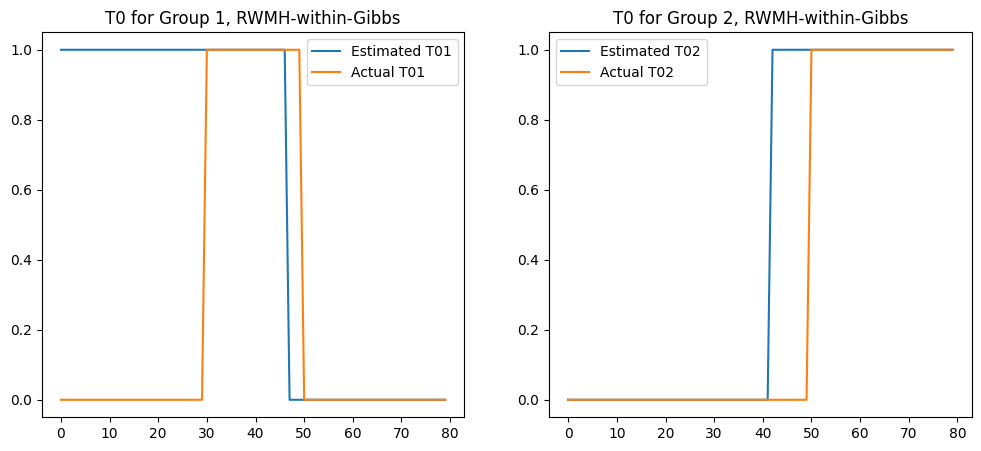

In [9]:
chain_T01 = np.array(chains[0][3300:])
chain_T02 = np.array(chains[1][3300:])

T01_est = np.median(chain_T01, axis = 0)
T02_est = np.median(chain_T02, axis = 0)

fig, ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].plot(range(g), T01_est,label='Estimated T01')
ax[0].plot(range(g), T01,label='Actual T01')
ax[0].legend(fontsize = 10)
ax[0].set_title('T0 for Group 1, RWMH-within-Gibbs')
ax[1].plot(range(g), T02_est,label='Estimated T02')
ax[1].plot(range(g), T02,label='Actual T02')
ax[1].legend(fontsize = 10)
ax[1].set_title('T0 for Group 2, RWMH-within-Gibbs')